To download dataset UTKFace, go here: 

https://www.kaggle.com/datasets/jangedoo/utkface-new/data

and download dataset, use the sub folder UTKFace (not the cropped part 1) and put it in this directory.

In [42]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [43]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from regression.model import CCVAE_Age
from regression.dataset import UTKFaceDataset
from torchvision import transforms

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = PROJECT_ROOT / "regression" / "model_weights" / "ccvae_age_balanced.pth"
DATA_DIR = PROJECT_ROOT / "data" / "UTKFace"

Z_C_DIM = 16           
Z_NOT_C_DIM = 64       

# --- LOAD DATA & MODEL ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = UTKFaceDataset(root_dir=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = CCVAE_Age(
        img_channels=3,
        z_c_dim=Z_C_DIM,
        z_not_c_dim=Z_NOT_C_DIM
    ).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Loaded model !")

def show_image(
    img_tensor,
    title=None,
    figsize=(3, 3),
    save_path=None,
):
    """
    Visualization for a single image tensor.

    Args:
        img_tensor (Tensor): Shape (1, C, H, W) or (C, H, W)
        title (str, optional): Figure title
        figsize (tuple): Figure size in inches
        save_path (str or Path, optional): If provided, saves the figure
    """
    img = img_tensor.detach().cpu()
    if img.dim() == 4:
        img = img.squeeze(0)

    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")

    if title is not None:
        plt.title(title, fontsize=12)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


UTKFace dataset loaded: 23708 images.
Loaded model !


Ground-truth age: 15 years
Predicted age: 19 years (Absolute error: 4 years)


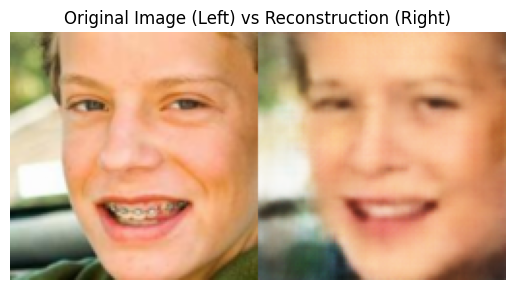

In [4]:
# Sample a random image
img, true_age_norm = dataset[np.random.randint(len(dataset))]
img = img.unsqueeze(0).to(DEVICE)
true_age = int(true_age_norm.item() * 100)

with torch.no_grad():
    recon, mu, _, pred_age_norm, _, _ = model(img)

    # Latent decomposition
    z_c = mu[:, :Z_C_DIM]        # Age-related latent
    z_not_c = mu[:, Z_C_DIM:]    # Identity / style latent

pred_age = int(pred_age_norm.item() * 100)

print(f"Ground-truth age: {true_age} years")
print(f"Predicted age: {pred_age} years (Absolute error: {abs(true_age - pred_age)} years)")

# Side-by-side visualization
viz = torch.cat([img, recon], dim=3)
show_image(
    viz,
    title="Original Image (Left) vs Reconstruction (Right)",
    figsize=(6, 3),
)


In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_image_grid(
    images,
    nrow,
    title=None,
    figsize=(12, 3),
    value_range=(0, 1)
):
    """
    Display a grid of images.

    Args:
        images (Tensor): shape (B, C, H, W)
        nrow (int): number of images per row
        title (str, optional)
        figsize (tuple)
        value_range (tuple): min/max for normalization
    """
    images = images.detach().cpu()

    # Make grid
    grid = vutils.make_grid(
        images,
        nrow=nrow,
        normalize=True,
        value_range=value_range,
        padding=2
    )

    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")

    if title is not None:
        plt.title(title, fontsize=11)

    plt.tight_layout()
    plt.show()


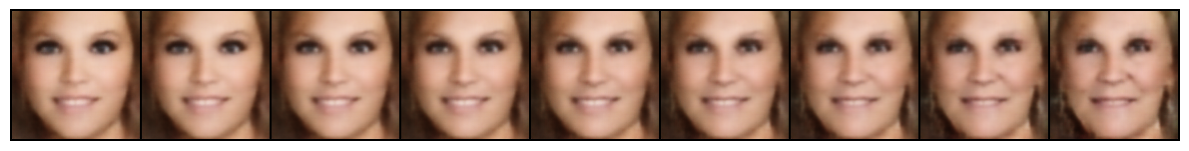

In [39]:
def visualize_aging(model, img_tensor, device="cuda"):
    """
    Age-conditioned traversal with fixed identity.
    """
    model.eval()

    with torch.no_grad():
        _, mu, _, _, _, _ = model(img_tensor)
        z_not_c = mu[:, Z_C_DIM:]  # Identity latent

        ages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
        target_ages = torch.tensor(
            [a / 100.0 for a in ages], device=device
        ).view(-1, 1)

        h_prior = model.prior_net(target_ages)
        z_c_targets = model.prior_mu(h_prior)

        z_not_c_rep = z_not_c.repeat(len(ages), 1)
        z = torch.cat([z_c_targets, z_not_c_rep], dim=1)

        dec_in = model.decoder_input(z).view(-1, 512, 4, 4)
        generated = model.decoder_conv(dec_in)

    show_image_grid(
        generated,
        nrow=len(ages),
        # title="Age progression with fixed identity (10–90 years)",
        figsize=(12, 3),
    )


# Example usage
batch_imgs, _ = next(iter(dataloader))
visualize_aging(model, batch_imgs[0:1].to(DEVICE), device=DEVICE)


Subject A age: 18 years | Subject B age: 22 years


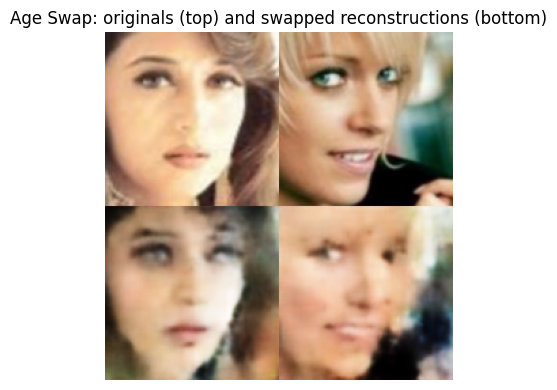

In [41]:
def swap_ages(model, img1, img2):
    """
    Age–identity swapping experiment.
    The age latent z_c is exchanged while preserving identity z_{¬c}.
    """
    model.eval()

    with torch.no_grad():
        _, mu1, _, age1, _, _ = model(img1)
        _, mu2, _, age2, _, _ = model(img2)

        z_c_1, z_not_c_1 = mu1[:, :Z_C_DIM], mu1[:, Z_C_DIM:]
        z_c_2, z_not_c_2 = mu2[:, :Z_C_DIM], mu2[:, Z_C_DIM:]

        z_swap_1 = torch.cat([z_c_2, z_not_c_1], dim=1)
        z_swap_2 = torch.cat([z_c_1, z_not_c_2], dim=1)

        recon1 = model.decoder_conv(
            model.decoder_input(z_swap_1).view(-1, 512, 4, 4)
        )
        recon2 = model.decoder_conv(
            model.decoder_input(z_swap_2).view(-1, 512, 4, 4)
        )

        top = torch.cat([img1, img2], dim=3)
        bottom = torch.cat([recon1, recon2], dim=3)
        comparison = torch.cat([top, bottom], dim=2)

    print(
        f"Subject A age: {int(age1.item() * 100)} years | "
        f"Subject B age: {int(age2.item() * 100)} years"
    )

    show_image(
        comparison,
        title="Age Swap: originals (top) and swapped reconstructions (bottom)",
        figsize=(8, 4),
    )

batch_imgs, _ = next(iter(dataloader))
swap_ages(
    model,
    batch_imgs[0:1].to(DEVICE),
    batch_imgs[1:2].to(DEVICE),
)
